In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn ,optim
from torch.utils.data import DataLoader
from torchvision import transforms , datasets
import torchvision


In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [35]:
transform = transforms.Compose([
    transforms.ToTensor()
])


train_data = datasets.MNIST('C:/Users/admin/OneDrive/프로그래밍\DeepLr',
                            train = True,
                            transform= transform,
                            download=True)

train_dataloader = DataLoader(train_data , 16 ,shuffle = True)


In [36]:
# model

class Encoder(nn.Module):

    def __init__(self , x_dim =784 , h1_dim = 196 , h2_dim = 49 ,z_dim =10):
        super(Encoder ,self).__init__()

        # 1st Hidden
        self.fc1 = nn.Sequential(
            nn.Linear(x_dim , h1_dim),
            nn.ReLU()
        )


        self.fc2 = nn.Sequential(
            nn.Linear(h1_dim , h2_dim),
            nn.ReLU()
        )


        # output_ layer 49 -> 10 (channels)
        
        # latent Vector 만드는 재료 (mean ,var)
        self.mean = nn.Linear(h2_dim , z_dim)
        self.var = nn.Linear(h2_dim , z_dim)


    def reparameterization(self , mean , var):

        #eps는 (0,1)에서 샘플링
        # mean + e*std 계산한거
        std = torch.exp(0.5 * var)
        eps = torch.randn_like(std)
        return mean + eps*std


    def forward(self ,x ):
        x = self.fc1(x)
        x = self.fc2(x)
        
        mean = self.mean(x)
        var = self.var(x)

        z = self.reparameterization(mean , var)
        return z , mean ,var
    

class Decoder(nn.Module):

    def __init__(self , x_dim =784 , h1_dim = 196 , h2_dim = 49 ,z_dim =10):
        super(Decoder ,self).__init__()


        # 1st hidden
        self.fc1 = nn.Sequential(
        nn.Linear(z_dim , h2_dim),
        nn.ReLU()
        )

        # 2nd hidden
        self.fc2 = nn.Sequential(
            nn.Linear(h2_dim , h1_dim),
            nn.ReLU()
        )
        

        # output
        self.fc3 = nn.Linear(h1_dim , x_dim)

    
    def forward(self,z):
        z = self.fc1(z)
        z = self.fc2(z)
        z = self.fc3(z)

        pred = nn.Sigmoid()(z)

        return pred

    

In [41]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)

parameters= list(encoder.parameters()) + list(decoder.parameters())

optimizer = optim.Adam(parameters , lr = 0.01)





In [42]:
# train

for ep in range(30):
    for i, (x, _) in enumerate(train_dataloader):
        # Forward
        input = x.view(16, -1).to(device)
        z, mu, logvar = encoder(input)
        output = decoder(z)

        # Reconstruction loss, Regularization loss 계산
        reconst_loss = nn.BCELoss(reduction='sum')(output, input)
        regular_loss = 0.5 * torch.sum(mu**2 + torch.exp(logvar) - logvar - 1)

        # Backward
        loss = reconst_loss + regular_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
  
    print(f" Loss : {loss}")


 Loss : 2362.747802734375
 Loss : 2249.78369140625
 Loss : 2411.745361328125
 Loss : 2324.45849609375
 Loss : 2168.07275390625
 Loss : 2380.5576171875
 Loss : 2394.4365234375
 Loss : 2094.03662109375
 Loss : 2674.721923828125
 Loss : 2136.68408203125
 Loss : 2101.733642578125
 Loss : 2331.1953125
 Loss : 2402.8681640625
 Loss : 2128.7109375
 Loss : 2194.4921875
 Loss : 2331.496337890625
 Loss : 2298.413818359375
 Loss : 2120.4609375
 Loss : 2315.09033203125
 Loss : 2266.544921875
 Loss : 1878.0277099609375
 Loss : 2188.855712890625
 Loss : 2009.2349853515625
 Loss : 2022.2562255859375
 Loss : 2332.845458984375
 Loss : 2448.234130859375
 Loss : 2396.125732421875
 Loss : 2346.497314453125
 Loss : 2088.83349609375
 Loss : 2466.22021484375


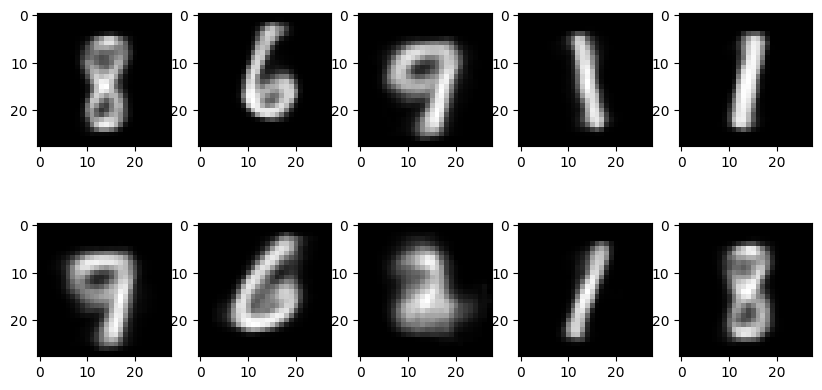

In [44]:
check_num_image = 10
z = torch.randn(check_num_image, 10).to(device)
sampled_images = decoder(z).view(check_num_image, 28, 28)
# 원본 이미지
img = plt.figure(figsize=(10, check_num_image //2))



# Inference 결과 시각화
fig = plt.figure(figsize=(10, (check_num_image//2)))
for idx, img in enumerate(sampled_images):
    ax = fig.add_subplot(2, check_num_image // 2, idx + 1)
    img = img.cpu().detach().numpy()  # CUDA 장치에서 호스트로 텐서를 복사한 후에 NumPy 배열로 변환
    ax.imshow(img, cmap='gray')

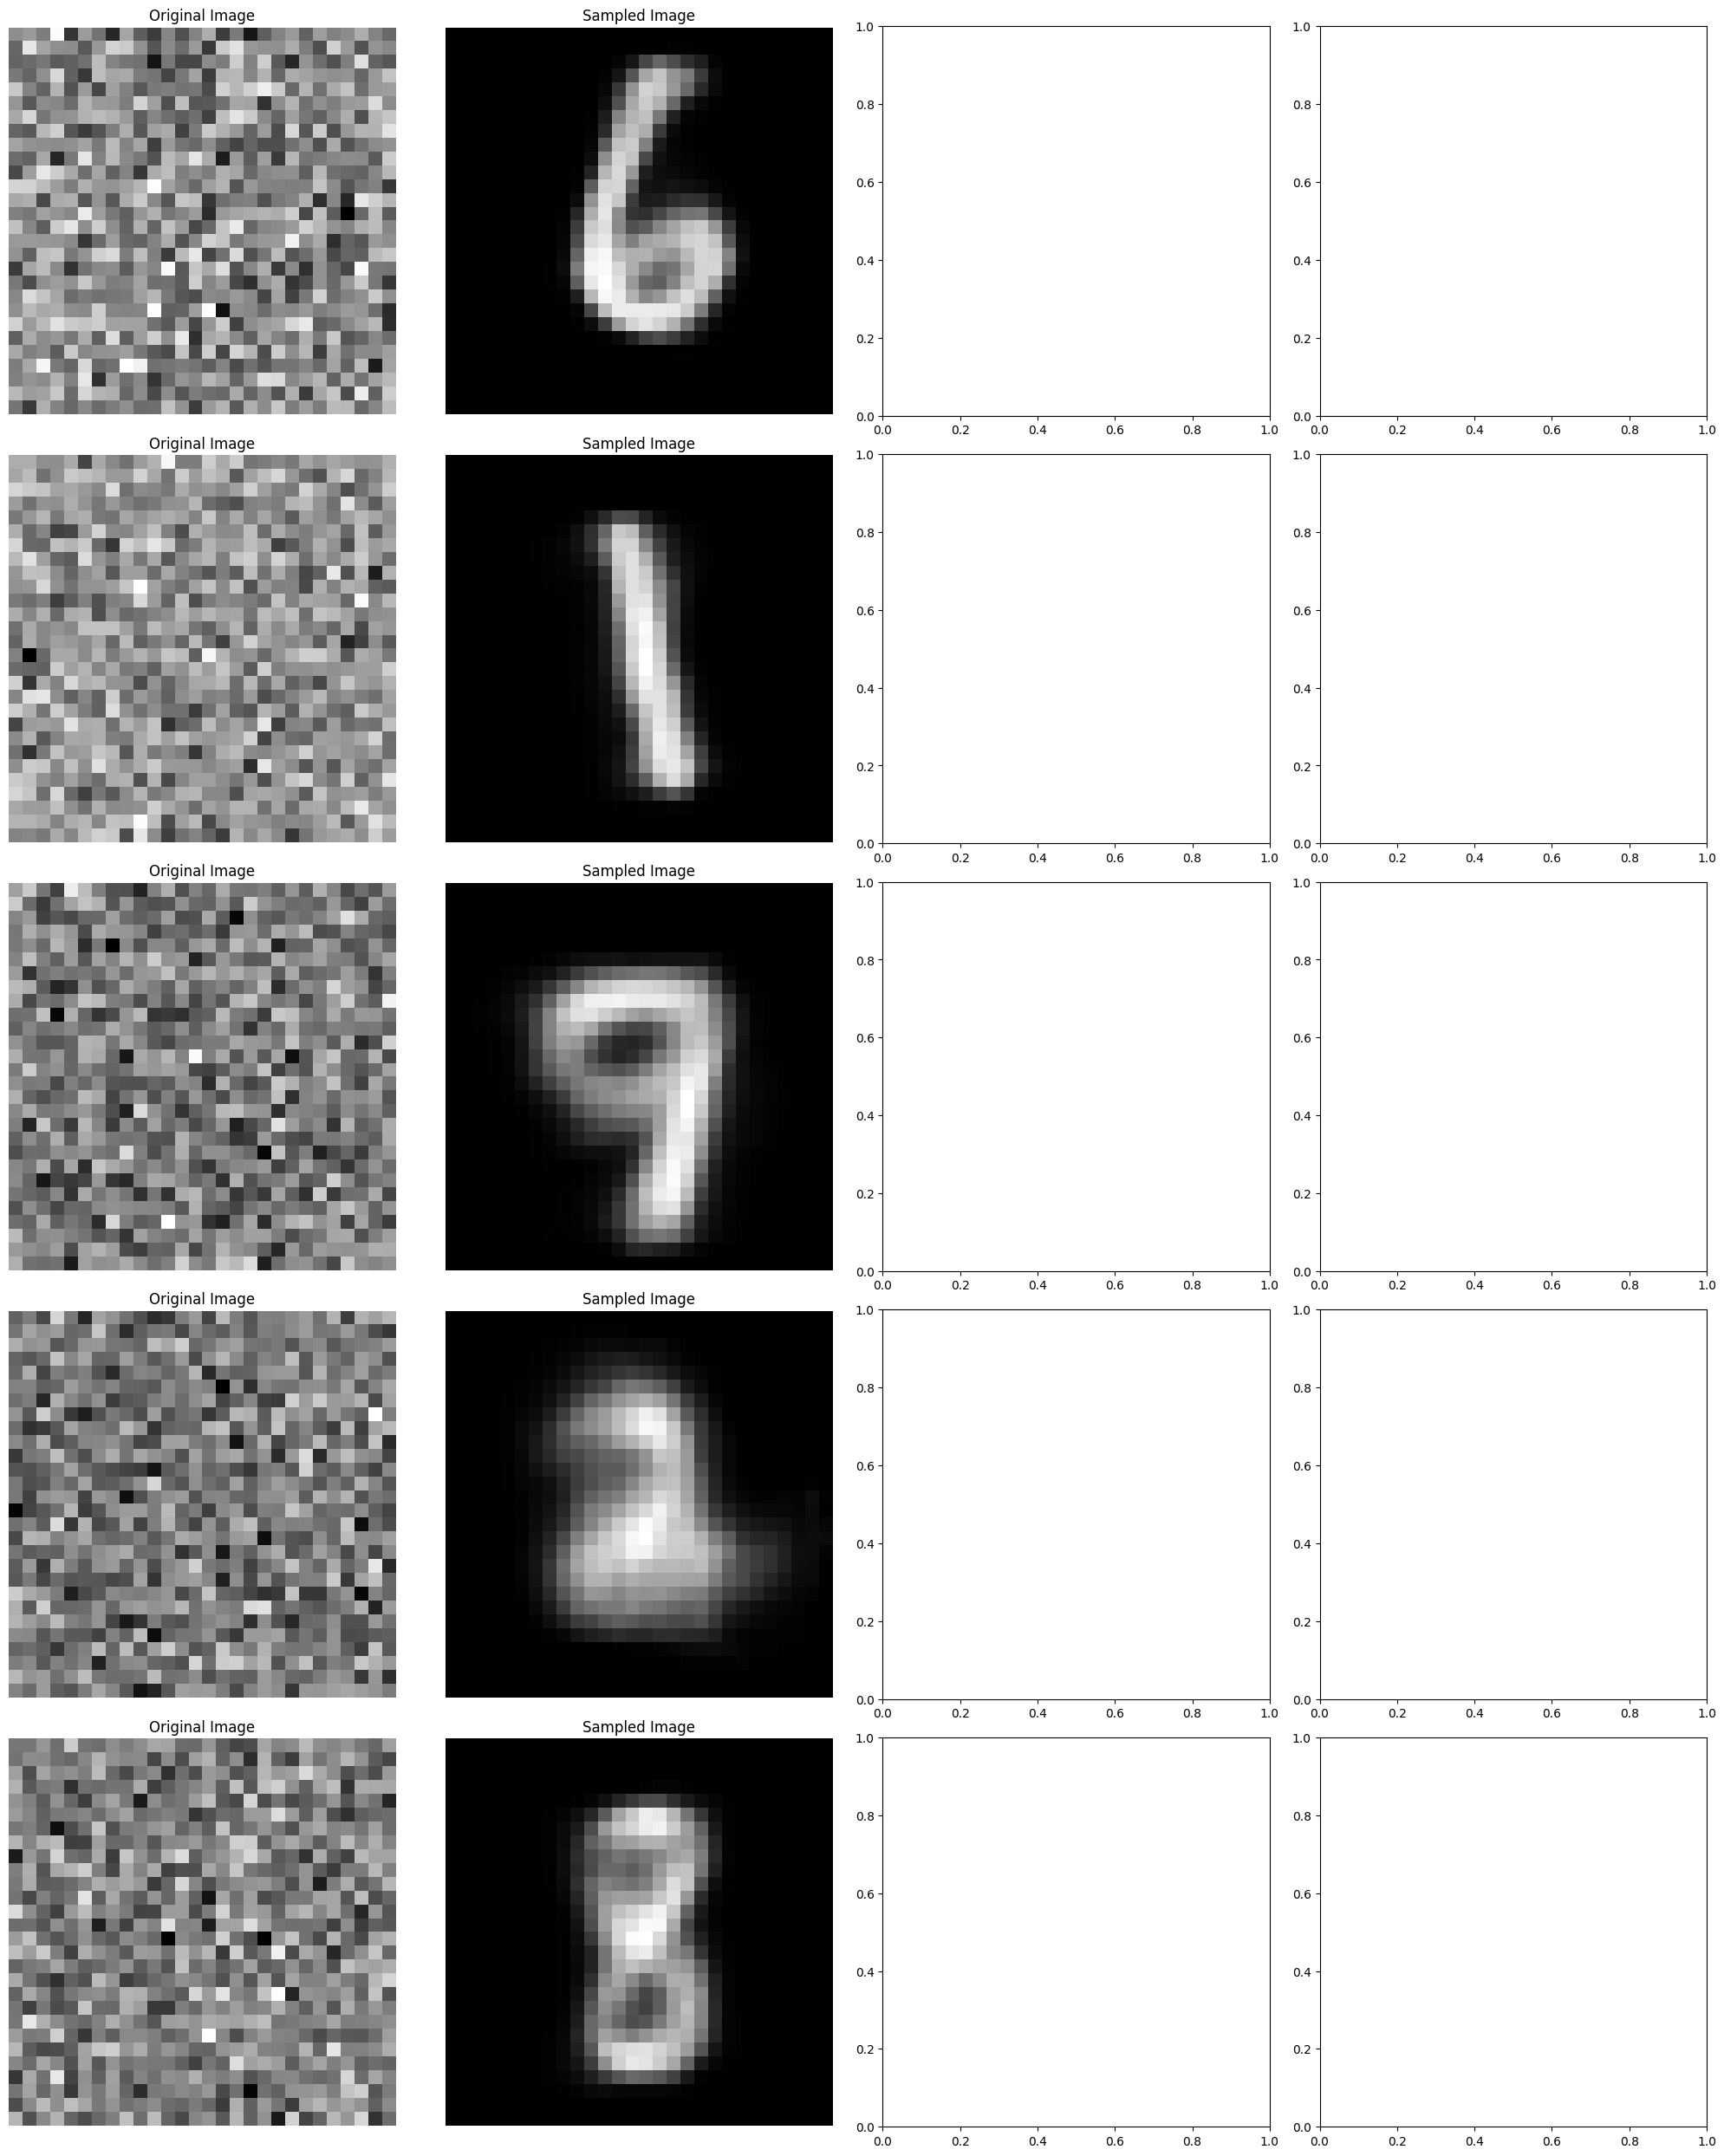

In [45]:
original_images = torch.randn(check_num_image, 28, 28)

# Plotting
fig, axes = plt.subplots(check_num_image // 2, 4, figsize=(20, check_num_image // 2 * 5))

for idx, (orig_img, samp_img) in enumerate(zip(original_images, sampled_images)):
    orig_ax = axes[idx // 2, 0]
    samp_ax = axes[idx // 2, 1]
    
    # Plot original image
    orig_ax.imshow(orig_img.cpu().detach().numpy(), cmap='gray')
    orig_ax.set_title('Original Image')
    orig_ax.axis('off')
    
    # Plot sampled image
    samp_ax.imshow(samp_img.cpu().detach().numpy(), cmap='gray')
    samp_ax.set_title('Sampled Image')
    samp_ax.axis('off')

plt.tight_layout()
plt.show()